# Animal Image Classification (DOG, CAT and PANDA)   
[Data Information]   
Data Source: https://www.kaggle.com/datasets/ashishsaxena2209/animal-image-datasetdog-cat-and-panda   
Data Folder Name : 'animals'   

[Image]   
cats: "cats_0001.jpg ~ cats_1000.jpg" (1,000)   
dogs: "dogs_0001.jpg ~ dogs_1000.jpg" (1,000)   
panda: "panda_0001.jpg ~ panda_1000.jpg" (1,000)   

[Version]   
Augmented, 64x64, ResNet

## 0. Setting

### Goole Drive Connecting

In [3]:
pwd

'/content'

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
%cd '/content/drive/MyDrive/Code Lion'

/content/drive/MyDrive/Code Lion


In [6]:
!ls

 Animal_Image_128.csv				 'CNN Lecture'
 Animal_Image_32.csv				  data
 Animal_Image_64.csv				  figure
'Animal Image Classification.ipynb'		  JunHyeok_Main.ipynb
'Animal Image Classification_Model1_0.73.ipynb'   model_save
'Animal Image Classification_Model1_0.76.ipynb'   Training_checkpoint
'Animal Image Classification_Model1_0.84.ipynb'


### Library Call

In [7]:
pip install tensorflow_addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [8]:
# 상용 라이브러리
from glob import glob
import os
import cv2
import pandas as pd
import numpy as np
import datetime as dt
import time

# 시각화 라이브러리
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import plotly.express as px
import plotly.graph_objects as go

# 한글 폰트 패치
matplotlib.rcParams['font.family']='Malgun Gothic'
matplotlib.rcParams['axes.unicode_minus'] = False   

# 시각화 포맷 설정
plt.style.use("ggplot")
sns.set(font_scale=1.5)
sns.set_style("whitegrid")
sns.set_context("talk")

# 경고문 처리
import warnings
warnings.filterwarnings('ignore')

# sckit-learn
from skimage.transform import resize   # 이미지 크기 조정
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score

# Tensorflow 라이브러리
import tensorflow as tf
from tensorflow import keras
from tqdm import tqdm
import tensorflow_addons as tfa
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers.core import Activation, Flatten, Dense
from keras import layers, models
from keras.utils import np_utils
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

### User Function Definition

In [9]:
# Constant Definition
class_label = {0:'cat', 1:'dog', 2:'panda'}
imgR = 64
imgC = 64
channel = 3

# Image Load
def load_img(flist): # path내의 모든 jpg 파일 불러오기
    img_list = []
    for file in flist:
        img = cv2.imread(file)
        img = resize(img, (imgR, imgC, channel))
        img_list.append(img)
    return np.array(img_list)

# plot_Images
def plot_Images(nRow, nCol, df):
  df = df.reset_index(drop=True)
  fig = plt.figure()
  fig, ax = plt.subplots(nRow, nCol, figsize=(nCol*4,nRow*4))
  for i in range(nRow):
    for j in range(nCol):
      if nRow <= 1 : axis = ax[j]
      else:          axis = ax[i,j]
      axis.set_title(f'label = {df.iloc[i*nCol+j,-1]}')
      axis.get_xaxis().set_visible(False)
      axis.get_yaxis().set_visible(False)
      axis.imshow(df.iloc[i*nCol+j,:-1].values.reshape(imgR,imgC,channel))
      plt.axis('off')
  plt.show()

# Get Clf Evaluation Metrics
def get_clf_eval(y_test,pred):
    cf = confusion_matrix(y_test,pred)
    acc = accuracy_score(y_test,pred)
    pre = precision_score(y_test,pred,average='macro')
    rec = recall_score(y_test,pred,average='macro')
    f1 = f1_score(y_test,pred,average='macro')
    
    print(cf)
    print('정확도 :{0:.4f}, 정밀도 :{1:.4f}, 재현율 :{2:.4f}, F1 :{3:.4f}'.format(acc,pre,rec,f1))
    # return [acc, pre, rec, f1]        

## 1. Data Load

In [ ]:
# glob Function jpg file Loading
cat_filst = sorted(glob('data/cats/*.jpg'))
dog_filst = sorted(glob('data/dogs/*.jpg'))
panda_filst = sorted(glob('data/panda/*.jpg'))

print('cat_filst :',len(cat_filst))
print('dog_filst :',len(dog_filst))
print('panda_filst :',len(panda_filst))

cat_filst : 1000
dog_filst : 1000
panda_filst : 1000


In [ ]:
cat_filst[:4]

['data/cats/cats_00001.jpg',
 'data/cats/cats_00002.jpg',
 'data/cats/cats_00003.jpg',
 'data/cats/cats_00004.jpg']

In [ ]:
# Image Loading
cat_image = load_img(cat_filst)
dog_image = load_img(dog_filst)
panda_image = load_img(panda_filst)

print('cat_image :',cat_image.shape)
print('dog_image :',dog_image.shape)
print('panda_image :',panda_image.shape)

cat_image : (1000, 64, 64, 3)
dog_image : (1000, 64, 64, 3)
panda_image : (1000, 64, 64, 3)


In [ ]:
# Image Concatenate
image = np.concatenate([cat_image,dog_image])
image = np.concatenate([image,panda_image])

In [ ]:
# Image DataFrame Definition
df = pd.DataFrame(image.reshape(3000,-1), columns = np.arange(imgR*imgC*channel))
df['label'] = np.array([[0]*len(cat_image),[1]*len(dog_image),[2]*len(panda_image)]).reshape(-1)
print('df.shape :',df.shape)
df.head(2)

df.shape : (3000, 12289)


,0,1,2,3,4,5,6,7,8,9,...,12279,12280,12281,12282,12283,12284,12285,12286,12287,label
0,0.649634,0.530084,0.323223,0.664400,0.549382,0.325852,0.670588,0.560784,0.327022,0.673897,...,0.043260,0.127145,0.196130,0.051532,0.134743,0.176471,0.110786,0.160112,0.215014,0
1,0.473496,0.389583,0.357994,0.531495,0.431985,0.409988,0.526072,0.445912,0.457677,0.552941,...,0.119301,0.119301,0.103663,0.123629,0.156365,0.184842,0.234528,0.245279,0.257261,0


In [ ]:
df.to_csv('Animal_Image_64.csv', index=False)

In [10]:
df = pd.read_csv('Animal_Image_64.csv')
df.head(2)

,0,1,2,3,4,5,6,7,8,9,...,12279,12280,12281,12282,12283,12284,12285,12286,12287,label
0,0.649634,0.530084,0.323223,0.664400,0.549382,0.325852,0.670588,0.560784,0.327022,0.673897,...,0.043260,0.127145,0.196130,0.051532,0.134743,0.176471,0.110786,0.160112,0.215014,0
1,0.473496,0.389583,0.357994,0.531495,0.431985,0.409988,0.526072,0.445912,0.457677,0.552941,...,0.119301,0.119301,0.103663,0.123629,0.156365,0.184842,0.234528,0.245279,0.257261,0


In [11]:
df['label'].value_counts()

0    1000
1    1000
2    1000
Name: label, dtype: int64

## 2. Data EDA & Preprocessing

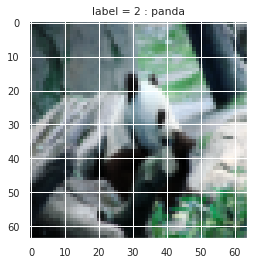

In [ ]:
# Random Image Sample Visualization
rnd_idx = np.random.randint(3000,size=1)
plt.imshow(df.iloc[rnd_idx,:-1].values.reshape(imgR,imgC,channel))
plt.title(f'label = {df.iloc[rnd_idx,-1].values[0]} : {class_label[df.iloc[rnd_idx,-1].values[0]]}')
plt.show()

<Figure size 432x288 with 0 Axes>

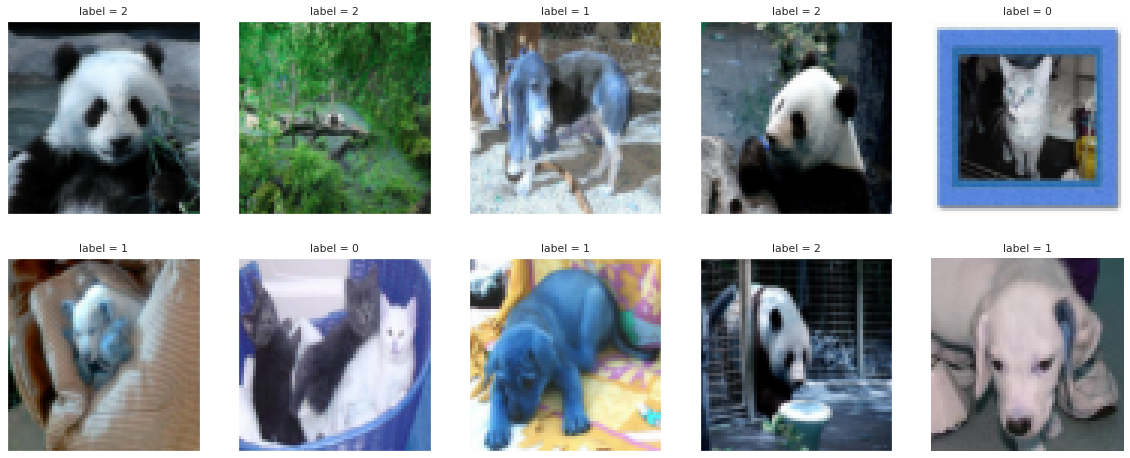

In [ ]:
# Random Image Samples Visualization
random_idx = np.random.randint(df.shape[0],size=10)
plot_Images(2,5,df.iloc[random_idx])

In [12]:
# Data and Target Split
X = df.drop('label',axis=1)
y = df['label']

# train_valid_test_split
X_temp, X_test, y_temp, y_test = train_test_split(X, y, stratify=y, random_state=42, test_size=0.2, shuffle=True)
X_train, X_valid, y_train, y_valid = train_test_split(X_temp, y_temp, stratify=y_temp, random_state=42, test_size=0.2, shuffle=True)

# Image Data Transformation
X_train = X_train.to_numpy().reshape(-1,imgR,imgC,channel)
X_valid = X_valid.to_numpy().reshape(-1,imgR,imgC,channel)
X_test = X_test.to_numpy().reshape(-1,imgR,imgC,channel)

print('X_train :',X_train.shape)
print('X_valid :',X_valid.shape)
print('X_test :',X_test.shape)
print('y_train :',y_train.shape)
print('y_valid :',y_valid.shape)
print('y_test :',y_test.shape)

X_train : (1920, 64, 64, 3)
X_valid : (480, 64, 64, 3)
X_test : (600, 64, 64, 3)
y_train : (1920,)
y_valid : (480,)
y_test : (600,)


In [13]:
# Image Augmentation
image_generator = ImageDataGenerator(
    rescale = 1/255.0,
    rotation_range = 60,
    brightness_range = [0.8,1.2],
    zoom_range = 0.1,
    shear_range = 0.2,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    horizontal_flip = False,
    vertical_flip = False,
    fill_mode = 'nearest'
)

augment_size = X_train.shape[0]
# np.random.seed(42)
# idx = np.random.randint(X_train.shape[0], size=augment_size)
# print('Augsize :',len(idx))

it = image_generator.flow(X_train, y_train, batch_size=augment_size, seed=42)

X_aug, y_aug = it.next()
for i in range(9):
  X_new, y_new = it.next()
  X_aug = np.concatenate((X_aug,X_new))
  y_aug = np.concatenate((y_aug,y_new))

print('X_aug.shape :',X_aug.shape)
print('y_aug.shape :',y_aug.shape)

X_aug.shape : (19200, 64, 64, 3)
y_aug.shape : (19200,)


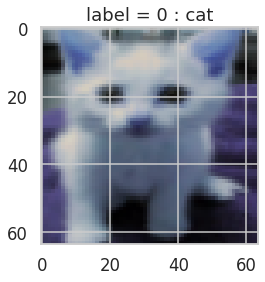

In [12]:
# Augmentation Image Sample Visualization
rnd_idx = np.random.randint(X_aug.shape[0],size=1)
plt.imshow(X_aug[rnd_idx][0])
plt.title(f'label = {y_aug[rnd_idx][0]} : {class_label[y_aug[rnd_idx][0]]}')
plt.show()

In [13]:
np.unique(y_aug, return_counts=True)

(array([0, 1, 2]), array([6400, 6400, 6400]))

In [14]:
# Train Data Integration
X_train = np.concatenate((X_train,X_aug))
y_train = np.concatenate((y_train,y_aug))

print('X_train.shape :',X_train.shape)
print('y_train.shape :',y_train.shape)

X_train.shape : (21120, 64, 64, 3)
y_train.shape : (21120,)


In [15]:
# # 임시 Integration
# X_train = X_aug
# y_train = y_aug

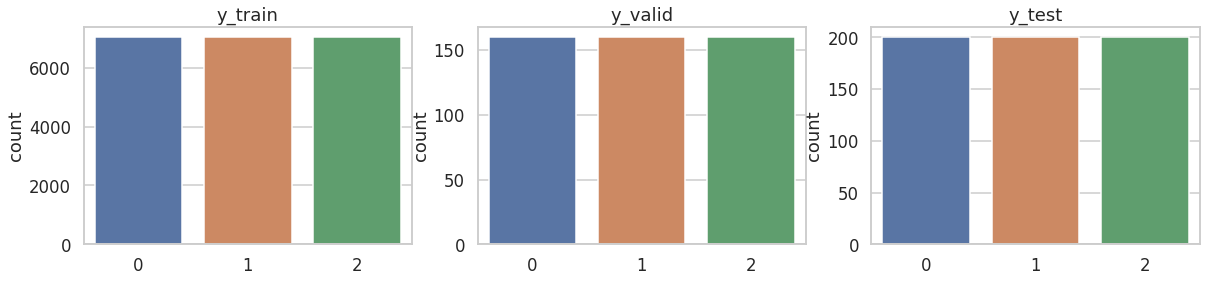

In [16]:
# Target value Distribution
fig, ax = plt.subplots(1,3,figsize=(20,4))

sns.countplot(y_train, ax=ax[0])
sns.countplot(y_valid.values, ax=ax[1])
sns.countplot(y_test.values, ax=ax[2])

ax[0].set_title('y_train')
ax[1].set_title('y_valid')
ax[2].set_title('y_test')
plt.show()

In [17]:
# One-Hot Encoding
y_train = pd.get_dummies(y_train).reset_index(drop=True)
y_valid = pd.get_dummies(y_valid).reset_index(drop=True)
y_test = pd.get_dummies(y_test).reset_index(drop=True)

print('y_train :',y_train.shape)
print('y_valid :',y_valid.shape)
print('y_test :',y_test.shape)

y_train : (21120, 3)
y_valid : (480, 3)
y_test : (600, 3)


## 3. Modeling

### Model 2. ResNet-34 CustomModel

In [41]:
# Identity Block (항등 블럭) 정의
def identity_block(X, filters, kernel_size):
    X_shortcut = X
    
    X = tf.keras.layers.Conv2D(filters, kernel_size, padding='SAME')(X)
    X = tf.keras.layers.BatchNormalization()(X)
    X = tf.keras.layers.Activation('relu')(X)
    X = tf.keras.layers.Dropout(0.3)(X)
    
    # X = tf.keras.layers.Conv2D(filters, kernel_size, padding='SAME')(X)
    # X = tf.keras.layers.BatchNormalization()(X)
    # X = tf.keras.layers.Activation('relu')(X)
    # X = tf.keras.layers.Dropout(0.3)(X)
    
    X = tf.keras.layers.Conv2D(filters, kernel_size, padding='SAME', kernel_regularizer = tf.keras.regularizers.L2(l2=0.01))(X)
    X = tf.keras.layers.BatchNormalization()(X)
    X = tf.keras.layers.Dropout(0.3)(X)
    
    # Add
    X = tf.keras.layers.Add()([X, X_shortcut])
    X = tf.keras.layers.Activation('relu')(X)
    
    return X

# Convolutional Bloack (컨볼루션 블럭) 정의
def convolutional_block(X, filters, kernel_size):
    X_shortcut = X
    
    X = tf.keras.layers.Conv2D(filters, kernel_size, padding='SAME', )(X)
    X = tf.keras.layers.BatchNormalization()(X)
    X = tf.keras.layers.Activation('relu')(X)
    X = tf.keras.layers.Dropout(0.3)(X)
    
    # X = tf.keras.layers.Conv2D(filters, kernel_size, padding='SAME')(X)
    # X = tf.keras.layers.BatchNormalization()(X)
    # X = tf.keras.layers.Activation('relu')(X)
    # X = tf.keras.layers.Dropout(0.3)(X)
    
    X = tf.keras.layers.Conv2D(filters, kernel_size, padding='SAME', kernel_regularizer = tf.keras.regularizers.L2(l2=0.01))(X)
    X = tf.keras.layers.BatchNormalization()(X)
    X = tf.keras.layers.Dropout(0.3)(X)

    X_shortcut = tf.keras.layers.Conv2D(filters, kernel_size, padding='SAME')(X_shortcut)
    X_shortcut = tf.keras.layers.BatchNormalization()(X_shortcut)
    
    # Add
    X = tf.keras.layers.Add()([X, X_shortcut])
    X = tf.keras.layers.Activation('relu')(X)
    
    return X

In [42]:
# ResNet2 모델 정의
def ResNet2(input_shape = (64, 64, 3), classes = 3):
    X_input = tf.keras.layers.Input(input_shape)
    X = X_input
    
    X = tf.keras.layers.Conv2D(64, (5,5), padding='SAME', strides=2, kernel_regularizer = tf.keras.regularizers.L2(l2=0.01))(X)
    X = tf.keras.layers.BatchNormalization()(X)
    X = tf.keras.layers.Activation('relu')(X)
    X = tf.keras.layers.MaxPooling2D(2, 2)(X)
    
    X = convolutional_block(X, 64, (3,3))
    X = identity_block(X, 64, (3,3))
    # X = identity_block(X, 64, (3,3))
    X = tf.keras.layers.MaxPooling2D(2, 2)(X)
    
    X = convolutional_block(X, 128, (3,3)) #64->128, use conv block
    X = identity_block(X, 128, (3,3))
    # X = identity_block(X, 128, (3,3))
    X = tf.keras.layers.MaxPooling2D(2, 2)(X)
    
    X = convolutional_block(X, 256, (3,3)) #128->256, use conv block
    X = identity_block(X, 256, (3,3))
    # X = identity_block(X, 256, (3,3))
    X = tf.keras.layers.MaxPooling2D(2, 2)(X)
    
    X = convolutional_block(X, 512, (3,3)) #256->512, use conv block
    X = identity_block(X, 512, (3,3))
    # X = identity_block(X, 512, (3,3))
    # X = tf.keras.layers.MaxPooling2D(2, 2)(X)
    
    X = tf.keras.layers.GlobalAveragePooling2D()(X)
    X = tf.keras.layers.Dense(256, kernel_regularizer = tf.keras.regularizers.L2(l2=0.01), activation='relu', kernel_initializer=tf.keras.initializers.GlorotNormal())(X)
    X = tf.keras.layers.BatchNormalization()(X)
    X = tf.keras.layers.Dropout(0.3)(X)
    X = tf.keras.layers.Dense(classes, activation = 'softmax')(X) # ouput layer (3 classes)
    
    model = tf.keras.models.Model(inputs = X_input, outputs = X, name = "ResNet2")
    
    return model

In [43]:
# ResNet Model 컴파일
model2 = ResNet2()

# ExponentialDecay Learning Rate Scheduler
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=10000,
    decay_rate=0.9)

# Model Compile
optimizer_use = tf.keras.optimizers.Adam(learning_rate = lr_schedule)
model2.compile(optimizer=optimizer_use, 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])

In [44]:
# Model Summary
model2.summary()

Model: "ResNet2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv2d_38 (Conv2D)             (None, 32, 32, 64)   4864        ['input_3[0][0]']                
                                                                                                  
 batch_normalization_40 (BatchN  (None, 32, 32, 64)  256         ['conv2d_38[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_34 (Activation)     (None, 32, 32, 64)   0           ['batch_normalization_40[0]

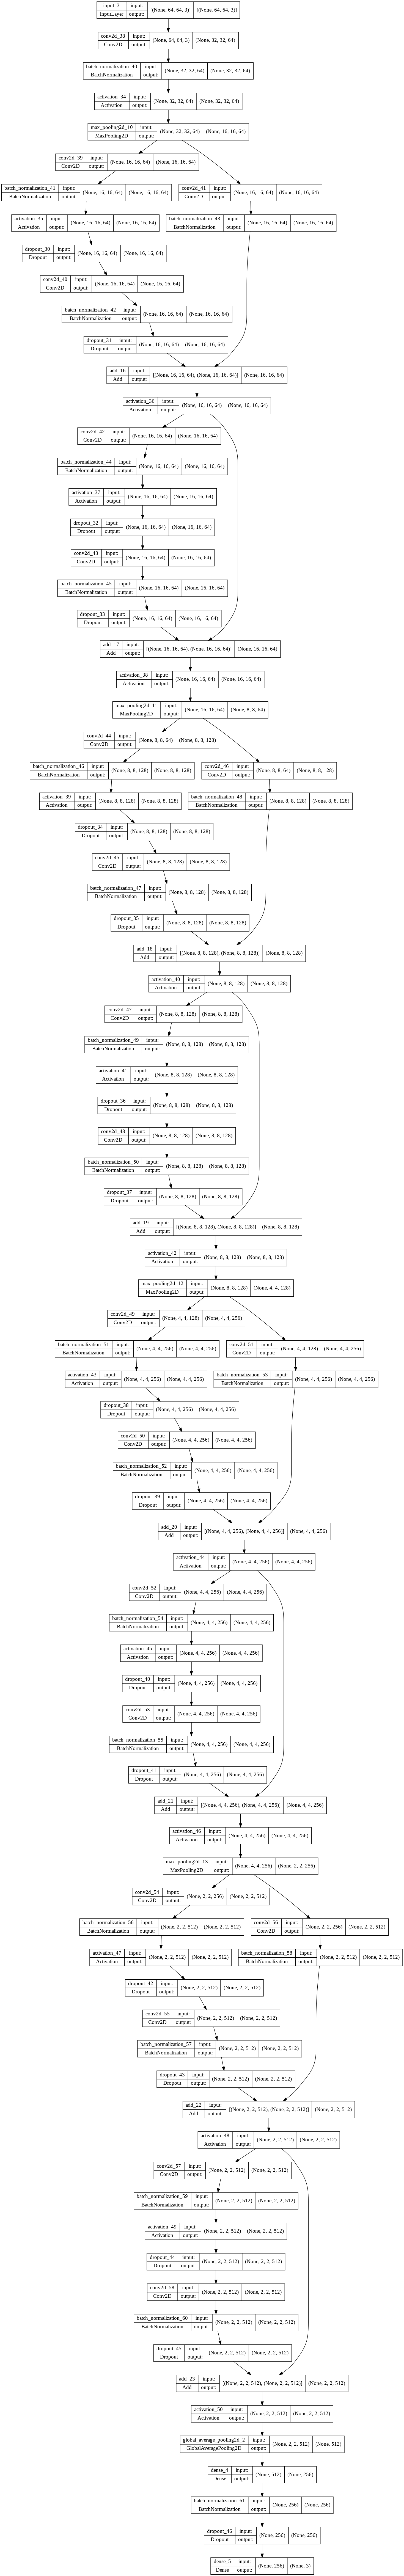

In [45]:
plot_model(model2, to_file='figure/model1_shapes.png', show_shapes=True)

In [46]:
# CallBack Functions
checkpoint_dir = 'Training_checkpoint/'
checkpoint_path = checkpoint_dir + 'cp-{epoch:04d}-{val_loss:.2f}.ckpt'
patience_time = 10

early_stopping = tf.keras.callbacks.EarlyStopping('val_loss', patience=patience_time)
cp = tf.keras.callbacks.ModelCheckpoint(filepath = checkpoint_path, verbose=1,
                                       save_weights_only = True,
                                       save_best_only = True)

In [47]:
# Training
tqdm_callback = tfa.callbacks.TQDMProgressBar()

start = time.time()
history = model2.fit(X_train, y_train, epochs=200, validation_data=(X_valid, y_valid),
                   batch_size=32, verbose=0,
                   callbacks=[early_stopping, cp, tqdm_callback])
end = time.time()
history

Training:   0%|           0/200 ETA: ?s,  ?epochs/s

Epoch 1/200


0/660           ETA: ?s - 


Epoch 1: val_loss improved from inf to 2.41402, saving model to Training_checkpoint/cp-0001-2.41.ckpt
Epoch 2/200


0/660           ETA: ?s - 


Epoch 2: val_loss did not improve from 2.41402
Epoch 3/200


0/660           ETA: ?s - 


Epoch 3: val_loss did not improve from 2.41402
Epoch 4/200


0/660           ETA: ?s - 


Epoch 4: val_loss did not improve from 2.41402
Epoch 5/200


0/660           ETA: ?s - 


Epoch 5: val_loss did not improve from 2.41402
Epoch 6/200


0/660           ETA: ?s - 


Epoch 6: val_loss did not improve from 2.41402
Epoch 7/200


0/660           ETA: ?s - 


Epoch 7: val_loss did not improve from 2.41402
Epoch 8/200


0/660           ETA: ?s - 


Epoch 8: val_loss improved from 2.41402 to 1.90260, saving model to Training_checkpoint/cp-0008-1.90.ckpt
Epoch 9/200


0/660           ETA: ?s - 


Epoch 9: val_loss did not improve from 1.90260
Epoch 10/200


0/660           ETA: ?s - 


Epoch 10: val_loss did not improve from 1.90260
Epoch 11/200


0/660           ETA: ?s - 


Epoch 11: val_loss improved from 1.90260 to 1.86294, saving model to Training_checkpoint/cp-0011-1.86.ckpt
Epoch 12/200


0/660           ETA: ?s - 


Epoch 12: val_loss did not improve from 1.86294
Epoch 13/200


0/660           ETA: ?s - 


Epoch 13: val_loss did not improve from 1.86294
Epoch 14/200


0/660           ETA: ?s - 


Epoch 14: val_loss improved from 1.86294 to 1.74792, saving model to Training_checkpoint/cp-0014-1.75.ckpt
Epoch 15/200


0/660           ETA: ?s - 


Epoch 15: val_loss improved from 1.74792 to 1.47701, saving model to Training_checkpoint/cp-0015-1.48.ckpt
Epoch 16/200


0/660           ETA: ?s - 


Epoch 16: val_loss did not improve from 1.47701
Epoch 17/200


0/660           ETA: ?s - 


Epoch 17: val_loss did not improve from 1.47701
Epoch 18/200


0/660           ETA: ?s - 


Epoch 18: val_loss did not improve from 1.47701
Epoch 19/200


0/660           ETA: ?s - 


Epoch 19: val_loss improved from 1.47701 to 1.36760, saving model to Training_checkpoint/cp-0019-1.37.ckpt
Epoch 20/200


0/660           ETA: ?s - 


Epoch 20: val_loss did not improve from 1.36760
Epoch 21/200


0/660           ETA: ?s - 


Epoch 21: val_loss did not improve from 1.36760
Epoch 22/200


0/660           ETA: ?s - 


Epoch 22: val_loss did not improve from 1.36760
Epoch 23/200


0/660           ETA: ?s - 


Epoch 23: val_loss did not improve from 1.36760
Epoch 24/200


0/660           ETA: ?s - 


Epoch 24: val_loss did not improve from 1.36760
Epoch 25/200


0/660           ETA: ?s - 


Epoch 25: val_loss did not improve from 1.36760
Epoch 26/200


0/660           ETA: ?s - 


Epoch 26: val_loss did not improve from 1.36760
Epoch 27/200


0/660           ETA: ?s - 


Epoch 27: val_loss did not improve from 1.36760
Epoch 28/200


0/660           ETA: ?s - 


Epoch 28: val_loss did not improve from 1.36760
Epoch 29/200


0/660           ETA: ?s - 


Epoch 29: val_loss did not improve from 1.36760


In [48]:
# Training Time Print
train_time = end-start
result = dt.timedelta(seconds=train_time)
print('Training Time :',str(result).split('.')[0])

Training Time : 0:09:12


In [49]:
# Training History DataFrame
df_hist = pd.DataFrame(history.history)
df_hist.head()

,loss,accuracy,val_loss,val_accuracy
0,5.872424,0.545786,2.414023,0.410417
1,1.961771,0.608570,2.422322,0.452083
2,1.831968,0.676989,2.544317,0.364583
3,1.781793,0.718182,2.518327,0.537500
4,1.548556,0.748816,2.837201,0.454167


In [50]:
# Best Estimator
df_hist.sort_values(by='val_loss').head(1)

,loss,accuracy,val_loss,val_accuracy
18,0.762329,0.953788,1.3676,0.741667


In [60]:
# # Model Save
# model2.save('model_save/ResNet_0.65/')

INFO:tensorflow:Assets written to: model_save/ResNet_0.65/assets


In [52]:
# # Model Load
# model2 = keras.models.load_model('model_save/ResNet_0.65/')

## 4. Performance Evaluation

### Learning Curve

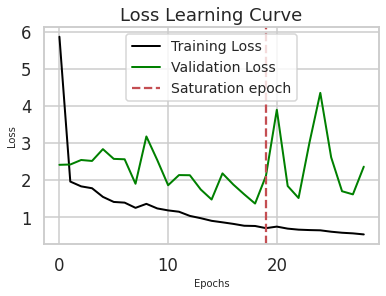

In [53]:
# Loss Learning Curve
plt.title('Loss Learning Curve')
plt.plot(df_hist.loss, label='loss', color='black', linewidth=2.0)
plt.plot(df_hist.val_loss, label='val_loss', color='green', linewidth=2.0)
plt.axvline(x=df_hist.shape[0]-patience_time, color='r', linestyle='--',label='best epoch')
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Loss', fontsize=10)
plt.legend(['Training Loss', 'Validation Loss', 'Saturation epoch'], fontsize=14)
plt.show()

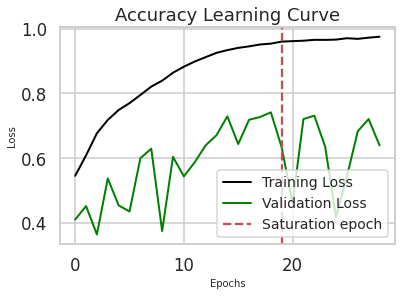

In [54]:
# Accuracy Learning Curve
plt.title('Accuracy Learning Curve')
plt.plot(df_hist.accuracy, label='accuracy', color='black', linewidth=2.0)
plt.plot(df_hist.val_accuracy, label='val_accuracy', color='green', linewidth=2.0)
plt.axvline(x=df_hist.shape[0]-patience_time, color='r', linestyle='--',label='best epoch')
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Loss', fontsize=10)
plt.legend(['Training Loss', 'Validation Loss', 'Saturation epoch'], fontsize=14)
plt.show()

### Test Data Evaluation

In [55]:
# Test Data Evaluation
test_loss, test_acc = model2.evaluate(X_test,y_test)
print('test loss :',np.round(test_loss,4))
print('test acc :',np.round(test_acc,4))

19/19 [==============================] - 1s 21ms/step - loss: 2.4240 - accuracy: 0.6517
test loss : 2.424
test acc : 0.6517


In [56]:
# Test Data Prediction
y_pred = model2.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis = 1)
y_true = np.argmax(y_test.to_numpy(), axis=1)

In [57]:
get_clf_eval(y_true,y_pred_classes)

[[ 36 138  26]
 [  8 180  12]
 [  2  23 175]]
정확도 :0.6517, 정밀도 :0.7107, 재현율 :0.6517, F1 :0.6019


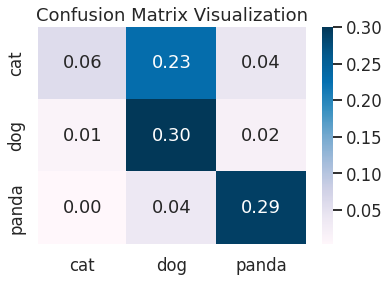

In [58]:
# Confusion Matrix Visualization
plt.title('Confusion Matrix Visualization')
sns.heatmap(confusion_matrix(y_true,y_pred_classes,normalize='all'), cmap='PuBu', annot=True, fmt='.2f')
plt.xticks([0.5,1.5,2.5],class_label.values())
plt.yticks([0.5,1.5,2.5],class_label.values())
plt.show()

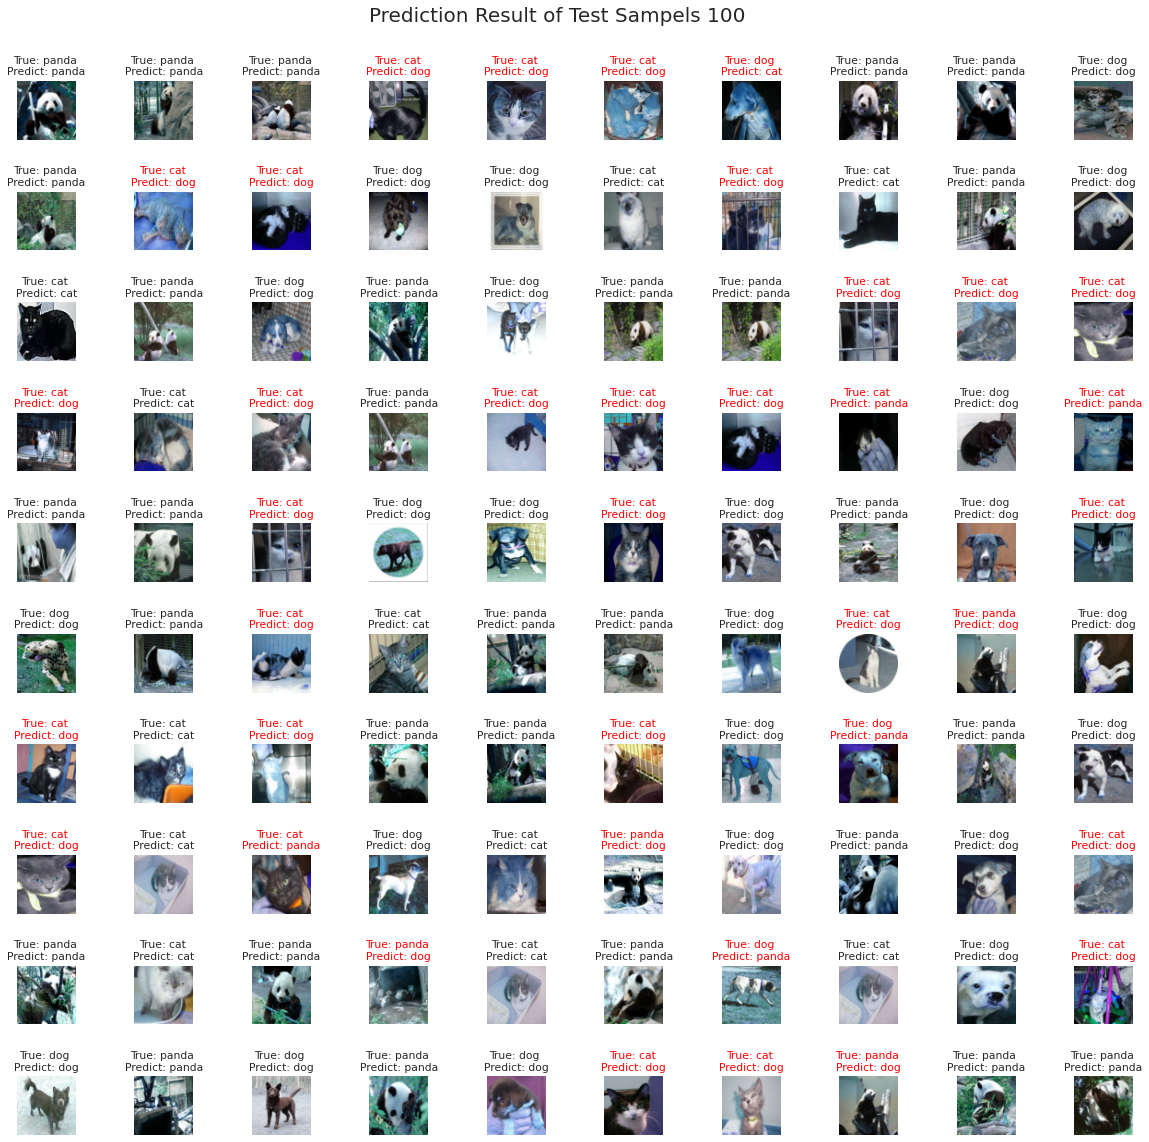

In [59]:
# Compare the Actual vs Predicted Results

sns.set(font_scale=0.9)
fig, axes = plt.subplots(10, 10, figsize=(20,20))
plt.suptitle('Prediction Result of Test Sampels 100', y=0.92, size=20)
axes = axes.ravel()

random_idx = np.random.randint(y_test.shape[0],size=100)

for i,idx in enumerate(random_idx):
  axes[i].imshow(X_test[idx])
  true_label, pred_label = class_label[y_true[idx]], class_label[y_pred_classes[idx]]
  if true_label != pred_label : axes[i].set_title('True: %s \nPredict: %s' % (true_label, pred_label), color='red')
  else: axes[i].set_title('True: %s \nPredict: %s' % (true_label, pred_label))
  axes[i].axis('off')
  plt.subplots_adjust(wspace=1)